In [1]:
import gym
import numpy as np

class CartPoleNonStationaryEnv(gym.Env):
    def __init__(self):
        self.env = gym.make("CartPole-v1")
        self.episode_counter = 0
        self.gravity_values = [9.8, 15.0, 5.0, 20.0]  # Different gravity settings
        self.change_interval = 10  # Change gravity every 10 episodes

    def reset(self):
        # Change gravity after every 'change_interval' episodes
        if self.episode_counter % self.change_interval == 0:
            new_gravity = np.random.choice(self.gravity_values)
            self.env.env.gravity = new_gravity
            print(f"Gravity changed to: {new_gravity}")
        
        self.episode_counter += 1
        return self.env.reset()

    def step(self, action):
        return self.env.step(action)

    def render(self):
        return self.env.render()

    def close(self):
        return self.env.close()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.softmax(x, dim=-1)

def select_action(policy_net, state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    probs = policy_net(state)
    action = torch.multinomial(probs, 1).item()
    return action, torch.log(probs[0, action])


In [5]:
def train_continual_backprop(env, policy_net, optimizer, episodes=1000, use_continual=False):
    gamma = 0.99
    reward_threshold = 195.0
    replacement_rate = 0.3 if use_continual else 0
    maturity_threshold = 10

    utility1, utility2 = torch.zeros(policy_net.fc1.out_features), torch.zeros(policy_net.fc2.out_features)
    age1, age2 = torch.zeros(policy_net.fc1.out_features), torch.zeros(policy_net.fc2.out_features)

    def replace_features(layer, utility, age, num_replacements):
        lowest_util_indices = utility.argsort()[:num_replacements]
        for i in lowest_util_indices:
            layer.weight.data[i, :] = torch.randn(layer.weight.shape[1]) * 0.01
            utility[i] = 0
            age[i] = 0

    for episode in range(episodes):
        state, _ = env.reset()
        rewards = []
        log_probs = []
        
        for t in range(1, 10000):  # Limit to 10000 steps
            action, log_prob = select_action(policy_net, state)
            state, reward, done, _,  _ = env.step(action)
            rewards.append(reward)
            log_probs.append(log_prob)
            if done:
                break
        
        # Compute discounted rewards
        discounted_rewards = []
        R = 0
        for r in reversed(rewards):
            R = r + gamma * R
            discounted_rewards.insert(0, R)
        discounted_rewards = torch.tensor(discounted_rewards)
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-5)

        # Update policy
        loss = -torch.sum(torch.stack(log_probs) * discounted_rewards)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track and update utility for continual backprop
        if use_continual:
            with torch.no_grad():
                # Compute activations for continual backprop
                state = torch.from_numpy(state).float()
                hidden_output1 = torch.relu(policy_net.fc1(state))
                hidden_output2 = torch.relu(policy_net.fc2(hidden_output1))

                # Update utility and age
                utility1 += torch.abs(hidden_output1)
                utility2 += torch.abs(hidden_output2)
                age1 += 1
                age2 += 1

                # Periodic replacement
                if episode % maturity_threshold == 0:
                    replace_features(policy_net.fc1, utility1, age1, int(replacement_rate * utility1.size(0)))
                    replace_features(policy_net.fc2, utility2, age2, int(replacement_rate * utility2.size(0)))

        # Logging
        total_reward = sum(rewards)
        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")
        if total_reward >= reward_threshold:
            print("Solved!")
            break


In [9]:
def train_continual_backprop(env, policy_net, optimizer, episodes=1000, use_continual=False, render_interval=50):
    gamma = 0.99
    reward_threshold = 195.0
    replacement_rate = 0.3 if use_continual else 0
    maturity_threshold = 10

    utility1, utility2 = torch.zeros(policy_net.fc1.out_features), torch.zeros(policy_net.fc2.out_features)
    age1, age2 = torch.zeros(policy_net.fc1.out_features), torch.zeros(policy_net.fc2.out_features)

    def replace_features(layer, utility, age, num_replacements):
        lowest_util_indices = utility.argsort()[:num_replacements]
        for i in lowest_util_indices:
            layer.weight.data[i, :] = torch.randn(layer.weight.shape[1]) * 0.01
            utility[i] = 0
            age[i] = 0

    for episode in range(episodes):
        state, _ = env.reset()
        rewards = []
        log_probs = []
        
        for t in range(1, 10000):  # Limit to 10000 steps
            if episode % render_interval == 0:
                env.render()  # Render every render_interval episodes
            
            action, log_prob = select_action(policy_net, state)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated  # Combine terminated and truncated into a single "done" flag
            rewards.append(reward)
            log_probs.append(log_prob)
            if done:
                break
        
        # Compute discounted rewards
        discounted_rewards = []
        R = 0
        for r in reversed(rewards):
            R = r + gamma * R
            discounted_rewards.insert(0, R)
        discounted_rewards = torch.tensor(discounted_rewards)
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-5)

        # Update policy
        loss = -torch.sum(torch.stack(log_probs) * discounted_rewards)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track and update utility for continual backprop
        if use_continual:
            with torch.no_grad():
                # Compute activations for continual backprop
                state = torch.from_numpy(state).float()
                hidden_output1 = torch.relu(policy_net.fc1(state))
                hidden_output2 = torch.relu(policy_net.fc2(hidden_output1))

                # Update utility and age
                utility1 += torch.abs(hidden_output1)
                utility2 += torch.abs(hidden_output2)
                age1 += 1
                age2 += 1

                # Periodic replacement
                if episode % maturity_threshold == 0:
                    replace_features(policy_net.fc1, utility1, age1, int(replacement_rate * utility1.size(0)))
                    replace_features(policy_net.fc2, utility2, age2, int(replacement_rate * utility2.size(0)))

        # Logging
        total_reward = sum(rewards)
        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")
        if total_reward >= reward_threshold:
            print("Solved!")
            break
    
    env.close()  # Close the environment window at the end of training


In [10]:
# Initialize environment, policy, and optimizer
env = CartPoleNonStationaryEnv()
policy_net = PolicyNetwork(input_dim=4, hidden_dim=128, output_dim=2)
optimizer = optim.Adam(policy_net.parameters(), lr=0.01)

# Run training with continual backprop
print("Training with Continual Backprop:")
train_continual_backprop(env, policy_net, optimizer, episodes=500, use_continual=True)

# Reset and train with standard backprop
policy_net = PolicyNetwork(input_dim=4, hidden_dim=128, output_dim=2)
optimizer = optim.Adam(policy_net.parameters(), lr=0.01)

print("\nTraining with Standard Backprop:")
train_continual_backprop(env, policy_net, optimizer, episodes=500, use_continual=False)

env.close()


Training with Continual Backprop:
Gravity changed to: 20.0
Episode 1/500, Total Reward: 20.0
Episode 2/500, Total Reward: 40.0
Episode 3/500, Total Reward: 17.0
Episode 4/500, Total Reward: 10.0
Episode 5/500, Total Reward: 13.0
Episode 6/500, Total Reward: 9.0
Episode 7/500, Total Reward: 10.0
Episode 8/500, Total Reward: 10.0
Episode 9/500, Total Reward: 9.0
Episode 10/500, Total Reward: 11.0
Gravity changed to: 15.0
Episode 11/500, Total Reward: 8.0
Episode 12/500, Total Reward: 12.0
Episode 13/500, Total Reward: 11.0
Episode 14/500, Total Reward: 11.0
Episode 15/500, Total Reward: 8.0
Episode 16/500, Total Reward: 9.0
Episode 17/500, Total Reward: 12.0
Episode 18/500, Total Reward: 13.0
Episode 19/500, Total Reward: 10.0
Episode 20/500, Total Reward: 18.0
Gravity changed to: 5.0
Episode 21/500, Total Reward: 13.0
Episode 22/500, Total Reward: 19.0
Episode 23/500, Total Reward: 17.0
Episode 24/500, Total Reward: 23.0
Episode 25/500, Total Reward: 12.0
Episode 26/500, Total Reward: 1

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gym/envs/classic_control/cartpole.py:211: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 53/500, Total Reward: 98.0
Episode 54/500, Total Reward: 82.0
Episode 55/500, Total Reward: 49.0
Episode 56/500, Total Reward: 59.0
Episode 57/500, Total Reward: 70.0
Episode 58/500, Total Reward: 48.0
Episode 59/500, Total Reward: 56.0
Episode 60/500, Total Reward: 27.0
Gravity changed to: 15.0
Episode 61/500, Total Reward: 41.0
Episode 62/500, Total Reward: 33.0
Episode 63/500, Total Reward: 38.0
Episode 64/500, Total Reward: 26.0
Episode 65/500, Total Reward: 35.0
Episode 66/500, Total Reward: 31.0
Episode 67/500, Total Reward: 32.0
Episode 68/500, Total Reward: 34.0
Episode 69/500, Total Reward: 23.0
Episode 70/500, Total Reward: 23.0
Gravity changed to: 20.0
Episode 71/500, Total Reward: 20.0
Episode 72/500, Total Reward: 28.0
Episode 73/500, Total Reward: 35.0
Episode 74/500, Total Reward: 25.0
Episode 75/500, Total Reward: 40.0
Episode 76/500, Total Reward: 40.0
Episode 77/500, Total Reward: 27.0
Episode 78/500, Total Reward: 34.0
Episode 79/500, Total Reward: 42.0
Episo

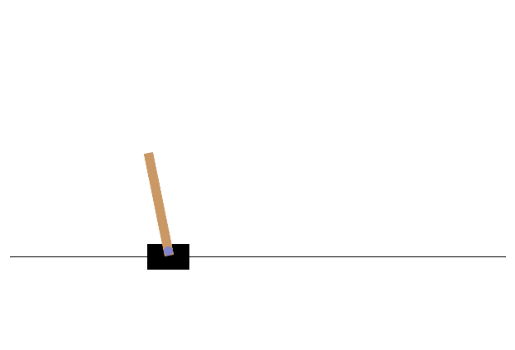

In [16]:
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

def visualize_policy_inline(env, policy_net, episodes=5):
    for episode in range(episodes):
        state, _ = env.reset()
        done = False
        while not done:
            # Render the frame and display it inline
            frame = env.render()  # No need for mode argument
            plt.imshow(frame)
            clear_output(wait=True)
            plt.axis('off')
            plt.show()
            time.sleep(0.02)  # Slow down for visibility

            action, _ = select_action(policy_net, state)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
    env.close()

# Use CartPole with `gymnasium`
env = gym.make("CartPole-v1", render_mode="rgb_array")
visualize_policy_inline(env, policy_net)
